<a href="https://colab.research.google.com/github/MehrdadHeyrani/Value-at-Risk-VaR-Modeling-in-Python/blob/main/VaR_and_Volatility_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***ARMA-GARCH Modeling, Volatility and Value at Risk (VaR) Forecasting*** **bold text**

# 1- Import and install

In [1]:
pip install arch

     |████████████████████████████████| 899 kB 28.2 MB/s 
     |████████████████████████████████| 9.8 MB 66.1 MB/s 
     |████████████████████████████████| 233 kB 76.1 MB/s 
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
pip install pandas-datareader

In [3]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 33.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=d7c207c8143c166b124c7aabee5d0198195dbcc0824794aa559ab30c209a496e
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
pip install yahoofinancials


  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15190 sha256=dea9bc07c03550f9ce18ef20a200c9b5864c270e55e6c3bf355d0c00f2168d61
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [5]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 31.5 MB/s 


# `1-1- Import and load package`

In [6]:
import datetime as dt
import sys
import numpy as np
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit


In [7]:
import pandas as pd
import warnings
import seaborn as sns
from pylab import rcParams 

%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="dark", color_codes=True)
rcParams['figure.figsize'] = 8,4

# 1-2- Download Data from Yahoo Finance

In [8]:
import yfinance as yf
from yahoofinancials import YahooFinancials
start_date='2010-01-01'
end_date=end='2021-09-01'

sp_data= yf.download('SPY',  # List of tickers
                      start='2010-01-01', 
                      end='2021-09-01', 
                      progress=False)
sp_data .head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,90.205025,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,90.443794,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,90.507484,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,90.889534,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,91.192024,126402800


In [9]:
# Calculate daily log returns
sp_data['Log_Return'] = np.log(sp_data['Adj Close']).diff().mul(100) 
sp_data = sp_data.dropna()

# 2- ARMA Modeling

## 2-1- Box-Jenkins Methodology

Box-Jenkins approach applies ARIMA models to find the best fit of a univariate time series model that represent the stochastic process. This method is including a three steps modelling: **1) identification, 2) estimation, 3) diagnostic checking**.


### 2-1-1- Unit Root Test 

In [11]:
# Unit Root ADF Test

result = adfuller(sp_data['Log_Return'] , autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -11.938121760991896
n_lags: 4.6107621763201435e-22
p-value: 4.6107621763201435e-22
Critial Values:
   1%, -3.4326007158683978
Critial Values:
   5%, -2.862534415652797
Critial Values:
   10%, -2.567299355555703


### 2-1-2- Identification
Based on the Autocorelation Function (ACF) and Partial Autocorrelation Function (PACF) it is possible to determine p, and q order of the ARIMA model. Also, we can use the Akaike Information Criterion (AIC) to identify the ARIMA order. 

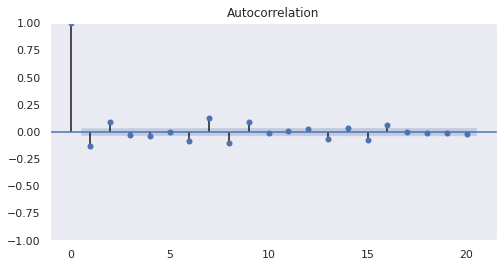

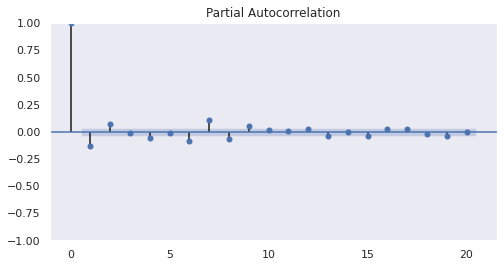

In [12]:
# using Autocorelation Function (ACF) and Partial Autocorrelation Function (PACF)
plot_acf(sp_data['Log_Return'] , lags=20)
plot_pacf(sp_data['Log_Return'] , lags=20)
pyplot.show()


In [13]:
# using the Akaike Information Criterion (AICc) 
# Find the optimal number of lags for ARMA model
import pmdarima as pm

model = pm.auto_arima(sp_data['Log_Return'],
d=0,       # I(d) order 
start_p=1, # AR(p)
start_q=1, #  MA(q)
max_p=5,   # max order of AR(p) 
max_q=5,   # max order of MA(q)                                         
seasonal=False, 
information_criterion='aic', # using AIC for selection best order for ARIMA(p,d,q)
trace=True, # print results
error_action='ignore', 
stepwise=True, )

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8711.274, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8769.284, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8721.454, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8728.501, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8708.022, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8706.064, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8707.964, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8706.060, Time=0.92 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8702.266, Time=1.40 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8701.746, Time=0.30 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8703.605, Time=0.38 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=8704.266, Time=1.22 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=8694.135, Time=0.68 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8701.336, Time=0.54 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept

### 2-1-3- Estimation of best ARMA(p,q) order

In [14]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2935
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -4304.131
Date:                Mon, 04 Oct 2021   AIC                           8628.262
Time:                        17:39:34   BIC                           8688.107
Sample:                             0   HQIC                          8649.812
                               - 2935                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0842      0.029      2.879      0.004       0.027       0.141
ar.L1         -0.1775      0.038     -4.726      0.000      -0.251      -0.104
ar.L2          0.7959      0.040     19.722      0.0

### 2-1-4- Diagnostics 

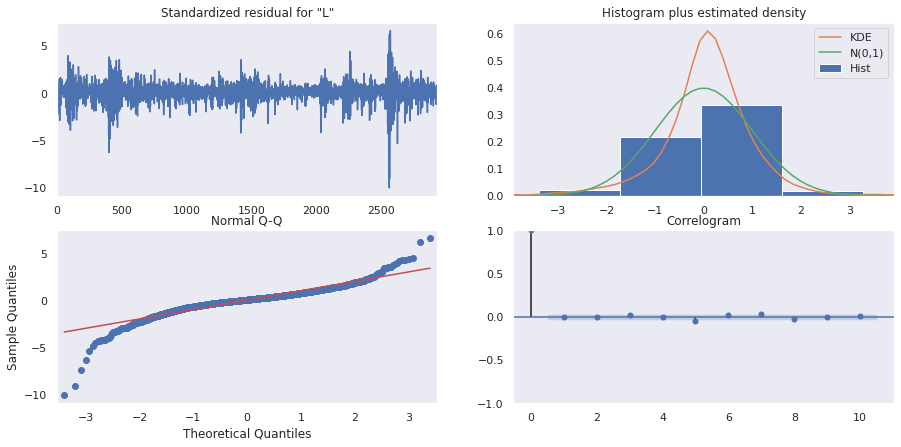

In [15]:
# Fit the best model after removing insignificant coefficients 
arma_model = sm.tsa.SARIMAX(endog=sp_data['Log_Return'],order=(4, 0, 4))
model_result = arma_model.fit()
# Residuals
model_result.plot_diagnostics(figsize=(15, 7))
plt.show()

# 3- GARCH Modeling 

Iteration:      4,   Func. Count:     37,   Neg. LLF: 3636.2780623470057
Iteration:      8,   Func. Count:     66,   Neg. LLF: 3635.611558445809
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3635.611337707447
            Iterations: 10
            Function evaluations: 78
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3635.61
Distribution:                  Normal   AIC:                           7279.22
Method:            Maximum Likelihood   BIC:                           7303.16
                                        No. Observations:                 2935
Date:                Mon, Oct 04 2021   Df Residuals:                     2934
Time:        

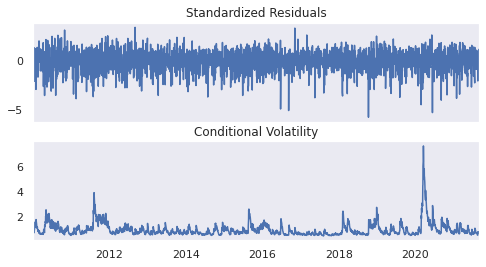

In [17]:
# GARCH normal model 
garch_norm= arch_model(sp_data['Log_Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
garch_norm_result = garch_norm.fit(update_freq = 4)

# Get summary
print(garch_norm_result.summary())

# Plot fitted results
garch_norm_result.plot()
plt.show()

In [18]:
# 4-step ahead forecast
garch_norm_result_forecast = garch_norm_result.forecast(horizon = 4)

# Print the forecast mean and variance
print(garch_norm_result_forecast.mean[-1:])
print(garch_norm_result_forecast.variance[-1:])

                 h.1       h.2       h.3       h.4
Date                                              
2021-08-31  0.090181  0.090181  0.090181  0.090181
                 h.1       h.2      h.3       h.4
Date                                             
2021-08-31  0.401092  0.427787  0.45359  0.478532


In [19]:
# GARCH skew t-student model 
garch_std = arch_model(sp_data['Log_Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
garch_std_result = garch_std.fit(disp = 'off')

# Get model estimated volatility
garch_std_vol = garch_std_result.conditional_volatility
garch_std_result = garch_std.fit(update_freq = 4)

# Get summary
print(garch_std_result.summary())

Iteration:      4,   Func. Count:     44,   Neg. LLF: 3536.2705840210538
Iteration:      8,   Func. Count:     80,   Neg. LLF: 3523.3354268261455
Iteration:     12,   Func. Count:    115,   Neg. LLF: 3522.4079219833257
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3522.407881980765
            Iterations: 14
            Function evaluations: 132
            Gradient evaluations: 14
                           Constant Mean - GARCH Model Results                           
Dep. Variable:                        Log_Return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -3522.41
Distribution:      Standardized Skew Student's t   AIC:                           7056.82
Method:                       Maximum Likelihood   BIC:                           7092.72
                              

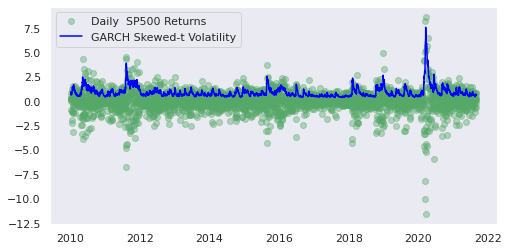

In [23]:
# Plot model fitting results
plt.plot(sp_data['Log_Return'], 'og', 
         label = 'Daily  SP500 Returns', alpha = 0.4)
plt.plot(garch_std_vol, color = 'blue', label = 'GARCH Skewed-t Volatility')

plt.legend(loc = ' right')
plt.show()

                             Zero Mean - GARCH Model Results                             
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -3564.18
Distribution:      Standardized Skew Student's t   AIC:                           7138.36
Method:                       Maximum Likelihood   BIC:                           7168.29
                                                   No. Observations:                 2935
Date:                           Mon, Oct 04 2021   Df Residuals:                     2935
Time:                                   17:42:11   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

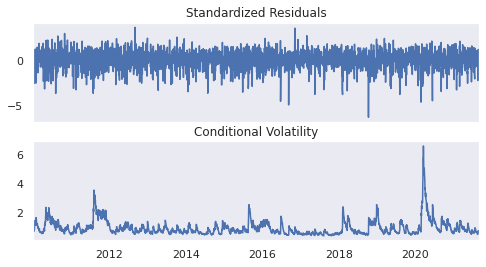

In [24]:
# Fit ARMA-GARCH skew t-student model 
garch_model = arch_model(model_result.resid, mean='Zero', p=1, q=1, dist = 'skewt')
garch_result = garch_model.fit(disp = 'off')

# Get summary
print(garch_result.summary())

# Plot GARCH model fitted results
garch_result.plot()
plt.show()

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3512.77
Distribution:      Standardized Student's t   AIC:                           7037.55
Method:                  Maximum Likelihood   BIC:                           7073.45
                                              No. Observations:                 2935
Date:                      Mon, Oct 04 2021   Df Residuals:                     2934
Time:                              17:42:29   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

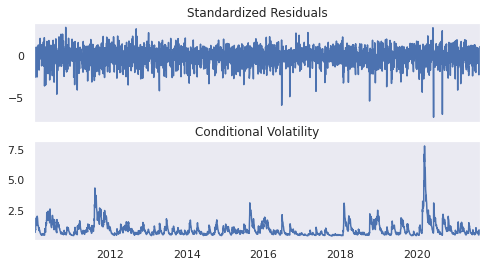

In [25]:
# ARMA-GJR-GARCH t-student model 
gjr = arch_model(model_result.resid , p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjr_result = gjr.fit(disp = 'off')

# Get summary
print(gjr_result.summary())

# Plot GJR-GARCH model fitted results
gjr_result.plot()
plt.show()

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -3505.15
Distribution:      Standardized Student's t   AIC:                           7022.30
Method:                  Maximum Likelihood   BIC:                           7058.21
                                              No. Observations:                 2935
Date:                      Mon, Oct 04 2021   Df Residuals:                     2934
Time:                              17:42:40   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

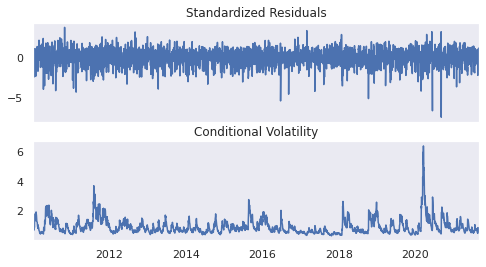

In [26]:
# ARMA-EGARCH t- student model 
egarch= arch_model(model_result.resid, p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch.fit(disp = 'off')

# Get summary
print(egarch_result.summary())

# Plot E-GARCH model fitted results
egarch_result.plot()
plt.show()

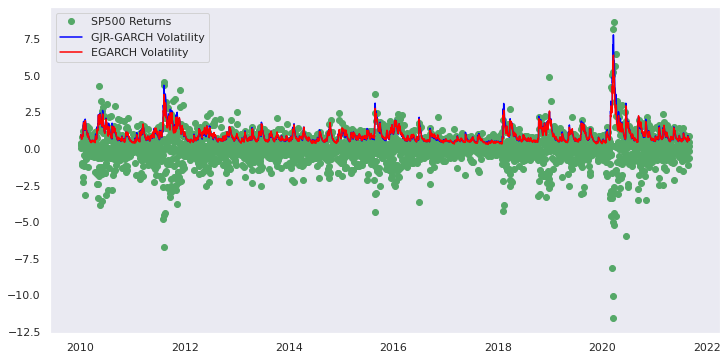

In [27]:
# Volatility plot
gjr_vol = gjr_result.conditional_volatility
egarch_vol = egarch_result.conditional_volatility

# Plot the actual returns
plt.figure(figsize=(12,6))
plt.plot(sp_data['Log_Return'], 'og', label = 'SP500 Returns')

# Plot GJR-GARCH estimated conditional volatility
plt.plot(gjr_vol, color = 'blue', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated conditional volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = ' left')
plt.show()

# 4- Volatility Forecasting

Volatility forecasting based on two diffrent approach:
1- Fixed Rolling Window,
2- Expanding window

In [44]:
egarch_model = arch_model(sp_data['Log_Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
egarch_fit = egarch_model.fit(disp='off', last_obs='2019-01-01')  # set last date for estimation (set In Sample data from start_date)

WS=len(sp_data[start_date:'2019-01-01']) # set Window size
print('Window Size:')
print(WS)

Out_of_sample=len(sp_data['2019-01-01':'2021-09-01']) # set oput of sample period 
print('Out ofsample lenght:')
print(Out_of_sample)


Window Size:
2263
Out ofsample lenght:
672


In [52]:
# Fixed rolling window mean and conditional variance forecasting

index = sp_data.index
start_loc = 0
end_loc = np.where(index >= '2019-1-1')[0].min() # starting date for forecasting

forecasts_var = {}
for i in range(len(sp_data['2019-01-01':'2021-01-01'])):
    egarch_fit = egarch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    cond_var  = egarch_fit.forecast(horizon=1).variance
    forcast_var = cond_var.iloc[i + end_loc - 1]
    forecasts_var[forcast_var.name] = forcast_var
print(' conditional variance forecast done!')

variance_fixedwin = pd.DataFrame(forecasts_var).T



 Mean forecast done!
 conditional variance forecast done!


In [53]:
# Expanding window mean and conditional variance forecasting

index = sp_data.index
start_loc = 0
end_loc = np.where(index >= '2019-01-01')[0].min() # starting date for forecasting

index = sp_data.index
start_loc = 0
end_loc = np.where(index >= '2019-1-1')[0].min()
forecasts = {}
for i in range(len(sp_data['2019-01-01':'2021-01-01'])):
    garch_fit = egarch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    cond_var = garch_fit.forecast(horizon=1).variance
    fcast = cond_var.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' conditional variance forecast done!')

variance_expandwin = pd.DataFrame(forecasts).T


 conditional variance forecast done!


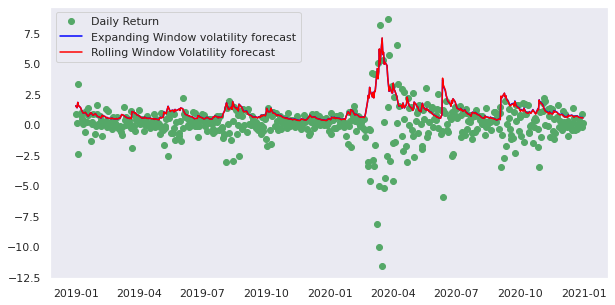

In [54]:
# Calculate volatility 
vol_expandwin = np.sqrt(variance_expandwin)
vol_fixedwin  = np.sqrt(variance_fixedwin)

# Volatility Plot 
plt.figure(figsize=(10,5))

plt.plot(sp_data.Log_Return.loc[variance_expandwin.index], 'og', label='Daily Return')
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window volatility forecast')
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window Volatility forecast')


plt.legend()
plt.show()


In [65]:
# Compare forecast results from different rolling window approaches
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print(f'Mean Absolute Error (MAE): {round(mae,3)}')
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print(f'Mean Squared Error (MSE): {round(mse,3)}')
    return mae, mse

# Backtest model with MAE, MSE
evaluate(sp_data['Log_Return'].sub(sp_data['Log_Return'].mean()).pow(2), egarch_vol**2)

Mean Absolute Error (MAE): 1.15
Mean Squared Error (MSE): 14.59


(1.1500191080081121, 14.589871599007596)

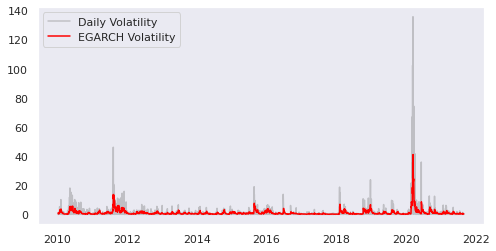

In [66]:
# Plot the actual return volatility
plt.plot(sp_data['Log_Return'].sub(sp_data['Log_Return'].mean()).pow(2), 
         color = 'grey', alpha = 0.4, label = 'Daily Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol**2, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = ' right')
plt.show()

# 4- Value at Risk (VaR) Forecasting and Backtesting

In [67]:
egarch_model = arch_model(sp_data['Log_Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
egarch_fit = egarch_model.fit(disp='off', last_obs='2019-01-01') 

In [68]:
q = egarch_model.distribution.ppf([0.99, 0.95], egarch_fit.params[5])
print(q)

[2.58446528 1.57618497]


In [69]:
len(sp_data['2019-01-01':'2021-01-01'])

505

In [50]:
# Fixed rolling window forecasting
index = sp_data.index
start_loc = 0
end_loc = np.where(index >= '2019-1-1')[0].min() # starting date for forecasting

forecasts_mean = {}
for i in range(len(sp_data['2019-01-01':'2021-01-01'])): # change the starting and ending date
    egarch_fit = egarch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    cond_mean = egarch_fit.forecast(horizon=1).mean
    forcast_mean = cond_mean.iloc[i + end_loc - 1]
    forecasts_mean[forcast_mean.name] = forcast_mean
print(' Mean forecast done!')

forecasts_var = {}
for i in range(len(sp_data['2019-01-01':'2021-01-01'])):
    egarch_fit = egarch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    cond_var  = egarch_fit.forecast(horizon=1).variance
    forcast_var = cond_var.iloc[i + end_loc - 1]
    forecasts_var[forcast_var.name] = forcast_var
print(' conditional variance forecast done!')

mean_fixedwin = pd.DataFrame(forecasts_mean).T
variance_fixedwin = pd.DataFrame(forecasts_var).T


 Mean forecast done!
 conditional variance forecast done!


In [190]:
# Expanding window forecast
index = sp_data.index
start_loc = 0
end_loc = np.where(index >= '2019-01-01')[0].min() # starting date for forecasting

index = sp_data.index
start_loc = 0
end_loc = np.where(index >= '2019-1-1')[0].min()

forecasts_m = {}
for i in range(len(sp_data['2019-01-01':'2021-01-01'])):
    garch_fit = egarch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    cond_mean = garch_fit.forecast(horizon=1).mean
    fcast_m = cond_mean.iloc[i + end_loc - 1]
    forecasts_m[fcast_m.name] = fcast_m
print(' mean forecast done!')

forecasts = {}
for i in range(len(sp_data['2019-01-01':'2021-01-01'])):
    garch_fit = egarch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    cond_var = garch_fit.forecast(horizon=1).variance
    fcast = cond_var.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' conditional variance forecast done!')


variance_expandwin = pd.DataFrame(forecasts).T
mean_expandwin = pd.DataFrame(forecasts_m).T


 mean forecast Done!
 conditional variance forecast Done!


In [192]:
# calculate VaR 
value_at_risk = -mean_fixedwin.values - np.sqrt(variance_fixedwin).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['VaR 1%', 'VaR 5%'], index=variance_fixedwin.index)

value_at_risk_E = -mean_expandwin.values - np.sqrt(variance_expandwin).values * q[None, :]
value_at_risk_E = pd.DataFrame(value_at_risk_E, columns=['VaR 1%', 'VaR 5%'], index=variance_expandwin.index)

value_at_risk.describe()
value_at_risk_E.describe()



,VaR 1%,VaR 5%
count,505.000000,505.000000
mean,-2.898452,-1.788564
std,2.228237,1.355950
min,-18.378302,-11.207417
25%,-3.338953,-2.055524
50%,-2.200134,-1.362540
75%,-1.599064,-1.000195
max,-0.961250,-0.609862


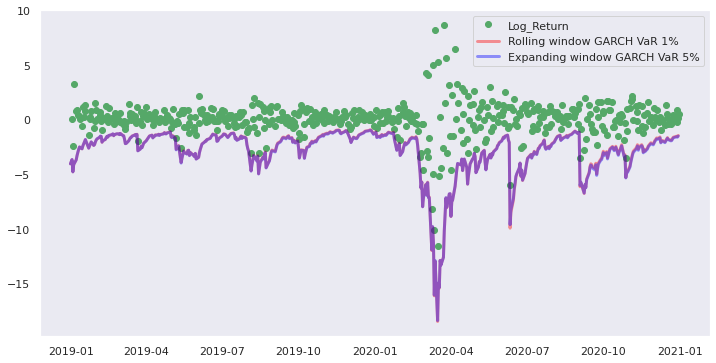

In [194]:
# VaR rolling and expanding window forecasting plot
plt.figure(figsize=(12,6))

plt.plot(sp_data.Log_Return['2019-01-01':'2021-01-01'],'og', label = 'Log_Return')
plt.plot(value_at_risk['VaR 1%'],  color = 'red', alpha = 0.4, label = 'Rolling window GARCH VaR 1%', linewidth=3)
plt.plot(value_at_risk_E['VaR 1%'],  color = 'blue', alpha = 0.4, label = 'Expanding window GARCH VaR 5%', linewidth=3)

# Plot VaR Rolling Forecasted
plt.legend(loc = ' right')
plt.show()

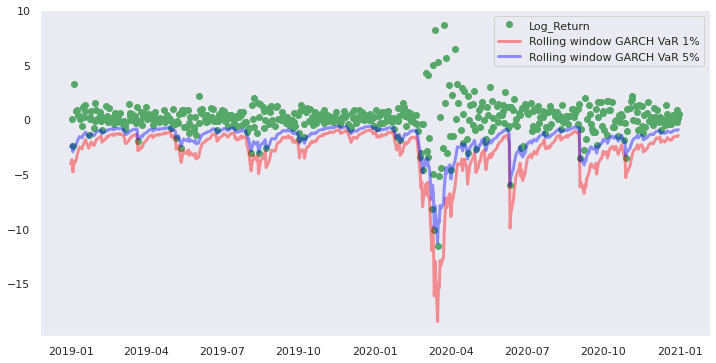

In [196]:
# VaR rolling forecasting plot
plt.figure(figsize=(12,6))

plt.plot(sp_data.Log_Return['2019-01-01':'2021-01-01'],'og', label = 'Log_Return')
plt.plot(value_at_risk['VaR 1%'],  color = 'red', alpha = 0.4, label = 'Rolling window GARCH VaR 1%', linewidth=3)
plt.plot(value_at_risk['VaR 5%'],  color = 'blue', alpha = 0.4, label = 'Rolling window GARCH VaR 5%', linewidth=3)

# Plot VaR Rolling Forecasted
plt.legend(loc = ' right')
plt.show()

In [72]:
forecasts = egarch_fit.forecast(start='2019-01-01')
cond_mean = forecasts.mean['2019':]
cond_var = forecasts.variance['2019':]
q = am.distribution.ppf([0.99, 0.95], res.params[5])
print(q)

[2.58446756 1.57618357]


In [73]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['VaR 1%', 'VaR 5%'], index=cond_var.index)
value_at_risk.describe()

,VaR 1%,VaR 5%
count,672.000000,672.000000
mean,-2.660580,-1.645437
std,1.985681,1.211003
min,-17.804550,-10.881257
25%,-3.001690,-1.853469
50%,-2.019173,-1.254264
75%,-1.599179,-0.998123
max,-0.961026,-0.608934


In [118]:
import numpy as np
y = np.diff(np.log(sp_data['Adj Close']), n=1, axis=0) # get returns

T = len(y)                   # number of obs for y
WE = 1000                    # estimation window length
p = 0.01                     # probability
l1 = int(WE * p)             # HS observation
value = 1                    # portfolio value
VaR = np.full([T,4], np.nan) # matrix for forecasts

## EWMA setup

lmbda = 0.94
s11 = np.var(y[1:30])

for t in range(1,WE):
    s11=lmbda*s11+(1-lmbda)*y[t-1]**2


In [77]:
import numpy as np
from scipy import stats
from arch import arch_model

for t in range(WE, T): 
    t1 = t - WE           # start of data window
    t2 = t - 1            # end of data window
    window = y[t1:t2+1]   # data for estimation

    s11 = lmbda * s11 + (1-lmbda) * y[t-1]**2
    VaR[t,0]=-stats.norm.ppf(p)*np.sqrt(s11)*value # EWMA
 
    VaR[t,1]=-np.std(window,ddof=1)*stats.norm.ppf(p)*value # MA

    ys = np.sort(window)
    VaR[t,2] = -ys[l1 - 1] * value # HS

    am = arch_model(window, mean = 'Zero',vol='Garch',
                    p=1, o=0, q=1, dist='Normal')
    res = am.fit(update_freq=0, disp='off',show_warning=False)
    par = [res.params[0], res.params[1], res.params[2]]
    s4 = par[0] + par[1] * window[WE - 1]**2 + par[2] * res.conditional_volatility[-1]**2
    VaR[t,3] = -np.sqrt(s4) * stats.norm.ppf(p) * value # GARCH(1,1)

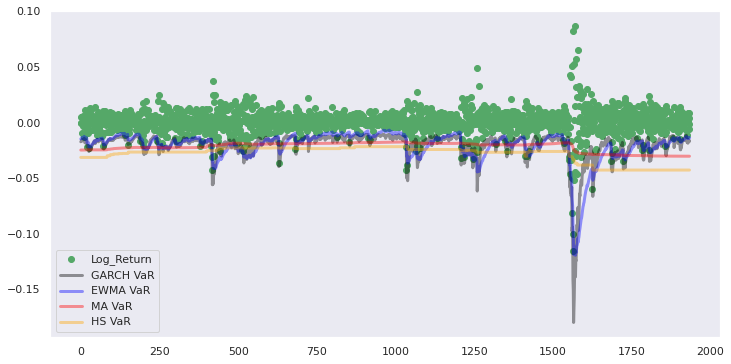

In [84]:
# VaR rolling forecasting plot
plt.figure(figsize=(12,6))
plt.plot(y[WE:T],'og', label = 'Log_Return')
plt.plot(-VaR[WE:T,3],  color = 'black', alpha = 0.4, label = 'GARCH VaR', linewidth=3)
plt.plot(-VaR[WE:T,0],  color = 'blue', alpha = 0.4, label = 'EWMA VaR', linewidth=3)
plt.plot(-VaR[WE:T,1],  color = 'red', alpha = 0.4, label = 'MA VaR', linewidth=3)
plt.plot(-VaR[WE:T,2],  color = 'orange', alpha = 0.4, label = 'HS VaR', linewidth=3)

# Plot VaR Rolling Forecasted
plt.legend(loc = ' right')
plt.show()